In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re

# 1. EDA

In [2]:
df_train = pd.read_csv('train.csv')
df_train.drop(columns=['Message ID', 'Unnamed: 0', 'split'], inplace=True)

df_val = pd.read_csv('val.csv')
df_val.drop(columns=['Message ID', 'Unnamed: 0', 'split'], inplace=True)

In [ ]:
df_train.info()

In [ ]:
print(df_train['Spam/Ham'].value_counts())

In [ ]:
df_train.head()

In [ ]:
print(f"Number of rows: {len(df_train)}")
print(f"Number of rows: {len(df_val)}")

In [ ]:
# Check for missing values

print("\nMissing values in training set:")
print(df_train.isnull().sum())
print("\nMissing values in validation set:")
print(df_val.isnull().sum())

# 2. Preprocessing

In [8]:
# Fill any NaN values with empty strings
df_train['Subject'] = df_train['Subject'].fillna('')
df_train['Message'] = df_train['Message'].fillna('')
df_val['Subject'] = df_val['Subject'].fillna('')
df_val['Message'] = df_val['Message'].fillna('')

# Create Bag of Words vectorizer for text features
bow = CountVectorizer(stop_words='english')

# Combine Subject and Message columns
df_train['text'] = df_train['Subject'] + ' ' + df_train['Message']
df_val['text'] = df_val['Subject'] + ' ' + df_val['Message']

# Transform text data to BoW features
X_train = bow.fit_transform(df_train['text'])
X_val = bow.transform(df_val['text'])

# Get labels
y_train = df_train['Spam/Ham']
y_val = df_val['Spam/Ham']

In [9]:
# # Convert sparse matrices to dense arrays properly
# X_train = X_train.toarray()
# y_train = np.array(y_train)
# X_val = X_val.toarray()
# y_val = np.array(y_val)

# 3. Naive Bayes

In [ ]:
# # Implement Multinomial Naive Bayes from scratch
# class MultinomialNB:
#     def __init__(self, alpha=1.0):
#         self.alpha = alpha  # Laplace smoothing parameter
#         self.class_priors = None
#         self.feature_probs = None
#         self.classes = None
        
#     def fit(self, X, y):
#         # Check if X is empty or 1-dimensional
#         if X.size == 0:
#             raise ValueError("Input array X is empty")
#         if len(X.shape) == 1:
#             X = X.reshape(1, -1)
            
#         # Get shape, handling both sparse and dense matrices
#         n_samples = X.shape[0]
#         n_features = X.shape[1]
            
#         self.classes = np.unique(y)
#         n_classes = len(self.classes)
        
#         # Calculate class priors P(y)
#         self.class_priors = np.zeros(n_classes)
#         for i, c in enumerate(self.classes):
#             self.class_priors[i] = np.sum(y == c) / n_samples
            
#         # Calculate feature probabilities P(x|y) with Laplace smoothing
#         # Process one class at a time to reduce memory usage
#         self.feature_probs = np.zeros((n_classes, n_features))
#         for i, c in enumerate(self.classes):
#             # Get indices of samples belonging to current class
#             class_indices = np.where(y == c)[0]
            
#             # Calculate feature counts in batches
#             feature_counts = np.zeros(n_features) + self.alpha
#             batch_size = 1000  # Adjust based on available memory
            
#             for start_idx in range(0, len(class_indices), batch_size):
#                 end_idx = min(start_idx + batch_size, len(class_indices))
#                 batch_indices = class_indices[start_idx:end_idx]
                
#                 # Sum features for current batch
#                 if isinstance(X, np.ndarray):
#                     batch_sum = X[batch_indices].sum(axis=0)
#                 else:
#                     batch_sum = X[batch_indices].toarray().sum(axis=0)
                    
#                 feature_counts += batch_sum
                
#             total_counts = feature_counts.sum()
#             self.feature_probs[i] = feature_counts / total_counts
            
#     def predict(self, X):
#         # Handle 1-dimensional input
#         if len(X.shape) == 1:
#             X = X.reshape(1, -1)
            
#         # Predict in batches to save memory
#         predictions = []
#         batch_size = 1000  # Adjust based on available memory
        
#         for start_idx in range(0, X.shape[0], batch_size):
#             end_idx = min(start_idx + batch_size, X.shape[0])
#             if isinstance(X, np.ndarray):
#                 batch = X[start_idx:end_idx]
#             else:
#                 batch = X[start_idx:end_idx].toarray()
                
#             batch_predictions = np.array([self._predict_single(x) for x in batch])
#             predictions.extend(batch_predictions)
            
#         return np.array(predictions)
    
#     def _predict_single(self, x):
#         # Calculate log probabilities to prevent numerical underflow
#         log_probs = np.log(self.class_priors)
        
#         # Add log of feature probabilities where feature is present (x > 0)
#         for i in range(len(self.classes)):
#             # Only consider non-zero features to save computation
#             present_features = x > 0
#             if np.any(present_features):
#                 # Multiply probability by feature count (for multinomial)
#                 log_probs[i] += np.sum(np.log(self.feature_probs[i][present_features]) * x[present_features])
        
#         # Return class with highest probability
#         return self.classes[np.argmax(log_probs)]

# # Train the model
# nb = MultinomialNB()
# nb.fit(X_train, y_train)

# # Make predictions
# y_pred = nb.predict(X_val)

# # Calculate accuracy
# accuracy = np.mean(y_pred == y_val)
# print(f"Validation Accuracy: {accuracy:.4f}")


# 4. Logistic Regression

Iteration 100, Train Loss: 0.069341, Val Loss: 0.082843
Iteration 200, Train Loss: 0.051172, Val Loss: 0.066666
Iteration 300, Train Loss: 0.042308, Val Loss: 0.058775
Iteration 400, Train Loss: 0.036779, Val Loss: 0.054015
Iteration 500, Train Loss: 0.032902, Val Loss: 0.050866
Iteration 600, Train Loss: 0.029997, Val Loss: 0.048658
Iteration 700, Train Loss: 0.027706, Val Loss: 0.046986
Iteration 800, Train Loss: 0.025842, Val Loss: 0.045672
Iteration 900, Train Loss: 0.024283, Val Loss: 0.044613
Iteration 1000, Train Loss: 0.022953, Val Loss: 0.043739


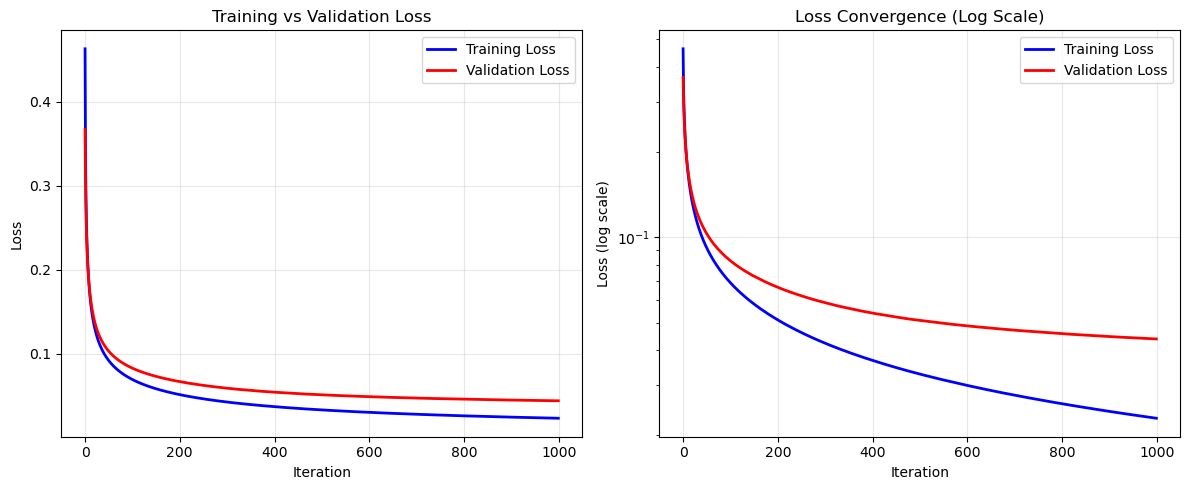

Initial Loss: 0.463076
Final Loss: 0.022953
Loss Reduction: 95.04%
Total Iterations: 1000
Validation Accuracy: 0.9887


In [17]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import sparse

# class LogisticRegression:
#     def __init__(self, learning_rate=0.01, max_iter=1000, batch_size=1000, tol=1e-6):
#         self.learning_rate = learning_rate
#         self.max_iter = max_iter
#         self.batch_size = batch_size
#         self.tol = tol
#         self.weights = None
#         self.bias = None
#         self.loss_history = []  # Thêm để lưu loss qua các iteration
        
#     def _sigmoid(self, z):
#         # Clip z để tránh overflow
#         z = np.clip(z, -250, 250)
#         return 1 / (1 + np.exp(-z))
    
#     def _get_batches(self, X, y, batch_size):
#         """Generator để chia dữ liệu thành batches"""
#         n_samples = X.shape[0]
#         for i in range(0, n_samples, batch_size):
#             end_idx = min(i + batch_size, n_samples)
#             if sparse.issparse(X):
#                 yield X[i:end_idx], y[i:end_idx]
#             else:
#                 yield X[i:end_idx], y[i:end_idx]
    
#     def fit(self, X, y, X_val=None, y_val=None):
#         # Convert labels to 0/1 if they're strings
#         if isinstance(y.iloc[0], str):
#             y = (y == 'spam').astype(int)
        
#         # Convert validation labels if provided
#         if X_val is not None and y_val is not None:
#             if isinstance(y_val.iloc[0], str):
#                 y_val = (y_val == 'spam').astype(int)
#             if hasattr(y_val, 'values'):
#                 y_val = y_val.values
        
#         n_samples, n_features = X.shape
        
#         # Initialize weights và bias
#         self.weights = np.zeros(n_features)
#         self.bias = 0
        
#         # Convert to numpy array if needed
#         if hasattr(y, 'values'):
#             y = y.values
            
#         prev_cost = float('inf')
#         self.loss_history = []  # Reset loss history
#         self.val_loss_history = []  # Thêm validation loss history
        
#         for iteration in range(self.max_iter):
#             total_cost = 0
#             n_batches = 0
            
#             # Shuffle indices for each epoch
#             indices = np.random.permutation(n_samples)
#             if sparse.issparse(X):
#                 X_shuffled = X[indices]
#             else:
#                 X_shuffled = X[indices]
#             y_shuffled = y[indices]
            
#             # Process each batch
#             for X_batch, y_batch in self._get_batches(X_shuffled, y_shuffled, self.batch_size):
#                 batch_size = X_batch.shape[0]
                
#                 # Forward pass
#                 if sparse.issparse(X_batch):
#                     z = X_batch.dot(self.weights) + self.bias
#                 else:
#                     z = np.dot(X_batch, self.weights) + self.bias
                
#                 predictions = self._sigmoid(z)
                
#                 # Compute cost for this batch
#                 epsilon = 1e-15  # Để tránh log(0)
#                 predictions = np.clip(predictions, epsilon, 1 - epsilon)
#                 batch_cost = -np.mean(y_batch * np.log(predictions) + 
#                                     (1 - y_batch) * np.log(1 - predictions))
#                 total_cost += batch_cost * batch_size
#                 n_batches += batch_size
                
#                 # Compute gradients
#                 dz = predictions - y_batch
#                 if sparse.issparse(X_batch):
#                     dw = X_batch.T.dot(dz) / batch_size
#                 else:
#                     dw = np.dot(X_batch.T, dz) / batch_size
#                 db = np.mean(dz)
                
#                 # Update weights và bias
#                 self.weights -= self.learning_rate * dw
#                 self.bias -= self.learning_rate * db
            
#             # Average cost across all batches
#             avg_cost = total_cost / n_batches
#             self.loss_history.append(avg_cost)
            
#             # Calculate validation loss if validation data is provided
#             if X_val is not None and y_val is not None:
#                 val_loss = self._calculate_loss(X_val, y_val)
#                 self.val_loss_history.append(val_loss)
            
#             # Check for convergence
#             if abs(prev_cost - avg_cost) < self.tol:
#                 print(f"Converged at iteration {iteration + 1}")
#                 break
                
#             prev_cost = avg_cost
            
#             if (iteration + 1) % 100 == 0:
#                 val_info = f", Val Loss: {self.val_loss_history[-1]:.6f}" if X_val is not None else ""
#                 print(f"Iteration {iteration + 1}, Train Loss: {avg_cost:.6f}{val_info}")
    
#     def _calculate_loss(self, X, y):
#         """Calculate loss for given data"""
#         if sparse.issparse(X):
#             z = X.dot(self.weights) + self.bias
#         else:
#             z = np.dot(X, self.weights) + self.bias
        
#         predictions = self._sigmoid(z)
#         epsilon = 1e-15
#         predictions = np.clip(predictions, epsilon, 1 - epsilon)
        
#         return -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    
#     def predict_proba(self, X):
#         """Predict probabilities with batch processing"""
#         n_samples = X.shape[0]
#         probabilities = np.zeros(n_samples)
        
#         start_idx = 0
#         for X_batch, _ in self._get_batches(X, np.zeros(n_samples), self.batch_size):
#             batch_size = X_batch.shape[0]
            
#             if sparse.issparse(X_batch):
#                 z = X_batch.dot(self.weights) + self.bias
#             else:
#                 z = np.dot(X_batch, self.weights) + self.bias
            
#             batch_proba = self._sigmoid(z)
#             probabilities[start_idx:start_idx + batch_size] = batch_proba
#             start_idx += batch_size
            
#         return probabilities
    
#     def predict(self, X):
#         """Predict with batch processing"""
#         probabilities = self.predict_proba(X)
#         return (probabilities >= 0.5).astype(int)
    
#     def plot_loss(self, figsize=(12, 5)):
#         """Visualize training loss"""
#         if not self.loss_history:
#             print("No loss history available. Train the model first.")
#             return
        
#         if len(self.val_loss_history) > 0:
#             # Plot both training and validation loss
#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            
#             # Training and validation loss
#             ax1.plot(self.loss_history, label='Training Loss', color='blue', linewidth=2)
#             ax1.plot(self.val_loss_history, label='Validation Loss', color='red', linewidth=2)
#             ax1.set_xlabel('Iteration')
#             ax1.set_ylabel('Loss')
#             ax1.set_title('Training vs Validation Loss')
#             ax1.legend()
#             ax1.grid(True, alpha=0.3)
            
#             # Log scale plot
#             ax2.semilogy(self.loss_history, label='Training Loss', color='blue', linewidth=2)
#             ax2.semilogy(self.val_loss_history, label='Validation Loss', color='red', linewidth=2)
#             ax2.set_xlabel('Iteration')
#             ax2.set_ylabel('Loss (log scale)')
#             ax2.set_title('Loss Convergence (Log Scale)')
#             ax2.legend()
#             ax2.grid(True, alpha=0.3)
#         else:
#             # Plot only training loss
#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            
#             # Normal scale
#             ax1.plot(self.loss_history, color='blue', linewidth=2)
#             ax1.set_xlabel('Iteration')
#             ax1.set_ylabel('Loss')
#             ax1.set_title('Training Loss')
#             ax1.grid(True, alpha=0.3)
            
#             # Log scale
#             ax2.semilogy(self.loss_history, color='blue', linewidth=2)
#             ax2.set_xlabel('Iteration')
#             ax2.set_ylabel('Loss (log scale)')
#             ax2.set_title('Training Loss (Log Scale)')
#             ax2.grid(True, alpha=0.3)
        
#         plt.tight_layout()
#         plt.show()
        
#         # Print some statistics
#         print(f"Initial Loss: {self.loss_history[0]:.6f}")
#         print(f"Final Loss: {self.loss_history[-1]:.6f}")
#         print(f"Loss Reduction: {((self.loss_history[0] - self.loss_history[-1]) / self.loss_history[0] * 100):.2f}%")
#         print(f"Total Iterations: {len(self.loss_history)}")

# model = LogisticRegression(learning_rate=0.1, max_iter=1000, batch_size=1000)
# model.fit(X_train, y_train, X_val, y_val)
# # Visualize loss
# model.plot_loss()
# # Predict 
# y_pred_train = model.predict(X_train)
# y_pred_val = model.predict(X_val)
# y_proba_val = model.predict_proba(X_val)
# # Calculate accuracy
# train_accuracy = np.mean(y_pred_train == (y_train == 'spam').astype(int))
# val_accuracy = np.mean(y_pred_val == (y_val == 'spam').astype(int))
# print(f"Validation Accuracy: {val_accuracy:.4f}")


# 5. XGBoost

In [18]:
# import numpy as np
# from scipy import sparse
# from collections import defaultdict
# import random

# class TreeNode:
#     def __init__(self):
#         self.feature_idx = None
#         self.threshold = None
#         self.left = None
#         self.right = None
#         self.value = None
#         self.is_leaf = False
        
# class XGBoostTree:
#     def __init__(self, max_depth=3, min_child_weight=0.1, reg_lambda=1.0, 
#                  reg_alpha=0.0, gamma=0.0, colsample_bytree=1.0):
#         self.max_depth = max_depth
#         self.min_child_weight = min_child_weight
#         self.reg_lambda = reg_lambda
#         self.reg_alpha = reg_alpha
#         self.gamma = gamma
#         self.colsample_bytree = colsample_bytree
#         self.root = None
#         self.feature_indices = None
        
#     def _calculate_leaf_weight(self, gradients, hessians):
#         """Calculate optimal leaf weight using Newton-Raphson"""
#         grad_sum = np.sum(gradients)
#         hess_sum = np.sum(hessians)
        
#         if hess_sum == 0:
#             return 0
            
#         weight = -grad_sum / (hess_sum + self.reg_lambda)
        
#         # Apply L1 regularization (soft thresholding)
#         if self.reg_alpha > 0:
#             if weight > self.reg_alpha:
#                 weight -= self.reg_alpha
#             elif weight < -self.reg_alpha:
#                 weight += self.reg_alpha
#             else:
#                 weight = 0
                
#         return weight
    
#     def _calculate_gain(self, left_grad, left_hess, right_grad, right_hess, parent_grad, parent_hess):
#         """Calculate gain from split"""
#         def calculate_score(grad_sum, hess_sum):
#             if hess_sum == 0:
#                 return 0
#             return (grad_sum ** 2) / (hess_sum + self.reg_lambda)
        
#         left_score = calculate_score(left_grad, left_hess)
#         right_score = calculate_score(right_grad, right_hess)
#         parent_score = calculate_score(parent_grad, parent_hess)
        
#         gain = 0.5 * (left_score + right_score - parent_score) - self.gamma
#         return gain
    
#     def _get_feature_column_sparse(self, X, feature_idx):
#         """Efficiently get feature column from sparse matrix"""
#         if sparse.issparse(X):
#             return X[:, feature_idx].toarray().flatten()
#         else:
#             return X[:, feature_idx]
    
#     def _find_best_split(self, X, gradients, hessians):
#         """Find best split for current node - memory efficient version"""
#         best_gain = -float('inf')
#         best_feature = None
#         best_threshold = None
#         best_left_indices = None
#         best_right_indices = None
        
#         n_samples, n_features = X.shape
        
#         # Sample features for this tree (column sampling) - more aggressive
#         if self.feature_indices is None:
#             n_features_sample = max(1, int(n_features * self.colsample_bytree))
#             # Allow more features but still limit for memory
#             n_features_sample = min(n_features_sample, 500)  # Increased from 100
#             self.feature_indices = np.random.choice(n_features, n_features_sample, replace=False)
        
#         # Try each sampled feature
#         for feature_idx in self.feature_indices:
#             # Get feature values efficiently
#             feature_values = self._get_feature_column_sparse(X, feature_idx)
            
#             # Skip if all values are the same
#             if len(np.unique(feature_values)) <= 1:
#                 continue
            
#             # More thresholds for better splits
#             unique_values = np.unique(feature_values)
#             if len(unique_values) > 20:
#                 # Use more quantiles for better splits
#                 percentiles = np.linspace(5, 95, 19)  # More percentiles
#                 thresholds = np.percentile(unique_values, percentiles)
#                 thresholds = np.unique(thresholds)
#             elif len(unique_values) > 10:
#                 # Use all unique values for medium-sized sets
#                 thresholds = unique_values[:-1]
#             else:
#                 thresholds = unique_values[:-1]
            
#             for threshold in thresholds:
#                 # Split samples
#                 left_mask = feature_values <= threshold
#                 right_mask = ~left_mask
                
#                 # Check minimum child weight constraint
#                 left_hess_sum = np.sum(hessians[left_mask])
#                 right_hess_sum = np.sum(hessians[right_mask])
                
#                 if left_hess_sum < self.min_child_weight or right_hess_sum < self.min_child_weight:
#                     continue
                
#                 # Calculate gain
#                 left_grad_sum = np.sum(gradients[left_mask])
#                 right_grad_sum = np.sum(gradients[right_mask])
#                 parent_grad_sum = np.sum(gradients)
#                 parent_hess_sum = np.sum(hessians)
                
#                 gain = self._calculate_gain(left_grad_sum, left_hess_sum,
#                                           right_grad_sum, right_hess_sum,
#                                           parent_grad_sum, parent_hess_sum)
                
#                 if gain > best_gain:
#                     best_gain = gain
#                     best_feature = feature_idx
#                     best_threshold = threshold
#                     best_left_indices = np.where(left_mask)[0]
#                     best_right_indices = np.where(right_mask)[0]
        
#         return best_gain, best_feature, best_threshold, best_left_indices, best_right_indices
    
#     def _build_tree(self, X, gradients, hessians, depth=0, indices=None):
#         """Recursively build tree - memory efficient version"""
#         if indices is None:
#             indices = np.arange(len(gradients))
        
#         node = TreeNode()
        
#         # Check stopping criteria
#         if (depth >= self.max_depth or 
#             len(indices) <= 1 or 
#             np.sum(hessians[indices]) < self.min_child_weight):
            
#             # Create leaf node
#             node.is_leaf = True
#             node.value = self._calculate_leaf_weight(gradients[indices], hessians[indices])
#             return node
        
#         # Get subset of data for current node
#         if sparse.issparse(X):
#             X_subset = X[indices]
#         else:
#             X_subset = X[indices]
#         grad_subset = gradients[indices]
#         hess_subset = hessians[indices]
        
#         # Find best split
#         gain, feature_idx, threshold, left_rel_indices, right_rel_indices = \
#             self._find_best_split(X_subset, grad_subset, hess_subset)
        
#         # If no good split found, create leaf
#         if gain <= 0 or feature_idx is None:
#             node.is_leaf = True
#             node.value = self._calculate_leaf_weight(grad_subset, hess_subset)
#             return node
        
#         # Create internal node
#         node.feature_idx = feature_idx
#         node.threshold = threshold
        
#         # Convert relative indices back to absolute indices
#         left_indices = indices[left_rel_indices]
#         right_indices = indices[right_rel_indices]
        
#         # Recursively build left and right subtrees
#         node.left = self._build_tree(X, gradients, hessians, depth + 1, left_indices)
#         node.right = self._build_tree(X, gradients, hessians, depth + 1, right_indices)
        
#         return node
    
#     def fit(self, X, gradients, hessians):
#         """Fit tree to gradients and hessians"""
#         self.root = self._build_tree(X, gradients, hessians)
    
#     def _predict_single_sparse(self, x_sparse, node):
#         """Predict single sparse sample recursively"""
#         if node.is_leaf:
#             return node.value
        
#         # Get feature value from sparse vector
#         if sparse.issparse(x_sparse):
#             feature_value = x_sparse[0, node.feature_idx]
#         else:
#             feature_value = x_sparse[node.feature_idx]
        
#         if feature_value <= node.threshold:
#             return self._predict_single_sparse(x_sparse, node.left)
#         else:
#             return self._predict_single_sparse(x_sparse, node.right)
    
#     def predict(self, X):
#         """Predict for multiple samples - memory efficient"""
#         predictions = np.zeros(X.shape[0])
        
#         if sparse.issparse(X):
#             # Process sparse matrix row by row to save memory
#             for i in range(X.shape[0]):
#                 x_row = X[i:i+1]  # Keep as sparse
#                 predictions[i] = self._predict_single_sparse(x_row, self.root)
#         else:
#             for i, x in enumerate(X):
#                 predictions[i] = self._predict_single_sparse(x, self.root)
        
#         return predictions

# class XGBoost:
#     def __init__(self, n_estimators=50, learning_rate=0.3, max_depth=6, 
#                  min_child_weight=1, subsample=0.8, colsample_bytree=0.8,
#                  reg_lambda=0.1, reg_alpha=0.0, gamma=0.0, 
#                  early_stopping_rounds=None, eval_metric='logloss',
#                  batch_size=500, random_state=42):
        
#         # Reduced defaults for memory efficiency
#         self.n_estimators = n_estimators
#         self.learning_rate = learning_rate
#         self.max_depth = max_depth
#         self.min_child_weight = min_child_weight
#         self.subsample = subsample
#         self.colsample_bytree = colsample_bytree
#         self.reg_lambda = reg_lambda
#         self.reg_alpha = reg_alpha
#         self.gamma = gamma
#         self.early_stopping_rounds = early_stopping_rounds
#         self.eval_metric = eval_metric
#         self.batch_size = batch_size
#         self.random_state = random_state
        
#         self.trees = []
#         self.base_prediction = 0
#         self.train_scores = []
#         self.val_scores = []
#         self.best_iteration = 0
        
#         # Set random seed
#         np.random.seed(random_state)
#         random.seed(random_state)
        
#     def _sigmoid(self, z):
#         """Sigmoid function with overflow protection"""
#         z = np.clip(z, -250, 250)
#         return 1 / (1 + np.exp(-z))
    
#     def _compute_gradients_hessians(self, y_true, y_pred):
#         """Compute gradients and hessians for logistic loss"""
#         p = self._sigmoid(y_pred)
#         gradients = p - y_true
#         hessians = p * (1 - p)
#         hessians = np.maximum(hessians, 1e-16)
#         return gradients, hessians
    
#     def _compute_loss(self, y_true, y_pred):
#         """Compute logistic loss"""
#         p = self._sigmoid(y_pred)
#         epsilon = 1e-15
#         p = np.clip(p, epsilon, 1 - epsilon)
#         return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    
#     def _get_batches(self, X, y=None, batch_size=None):
#         """Generator để chia dữ liệu thành batches"""
#         if batch_size is None:
#             batch_size = self.batch_size
            
#         n_samples = X.shape[0]
#         for i in range(0, n_samples, batch_size):
#             end_idx = min(i + batch_size, n_samples)
#             if y is not None:
#                 yield X[i:end_idx], y[i:end_idx]
#             else:
#                 yield X[i:end_idx]
    
#     def fit(self, X_train, y_train, X_val=None, y_val=None, verbose=True):
#         """Fit XGBoost model - memory efficient version"""
#         # Convert labels to 0/1 if they're strings
#         if hasattr(y_train, 'iloc') and isinstance(y_train.iloc[0], str):
#             y_train = (y_train == 'spam').astype(int)
#         if hasattr(y_train, 'values'):
#             y_train = y_train.values
            
#         if X_val is not None and y_val is not None:
#             if hasattr(y_val, 'iloc') and isinstance(y_val.iloc[0], str):
#                 y_val = (y_val == 'spam').astype(int)
#             if hasattr(y_val, 'values'):
#                 y_val = y_val.values
        
#         n_samples = X_train.shape[0]
        
#         # Initialize base prediction (log odds)
#         pos_rate = np.mean(y_train)
#         pos_rate = np.clip(pos_rate, 1e-15, 1 - 1e-15)
#         self.base_prediction = np.log(pos_rate / (1 - pos_rate))
        
#         # Initialize predictions
#         train_predictions = np.full(n_samples, self.base_prediction)
#         if X_val is not None:
#             val_predictions = np.full(X_val.shape[0], self.base_prediction)
        
#         if verbose:
#             print(f"Starting XGBoost training with {self.n_estimators} estimators...")
#             print(f"Data shape: {X_train.shape}, Sparse: {sparse.issparse(X_train)}")
#             print(f"Base prediction: {self.base_prediction:.4f}")
        
#         best_val_score = float('inf')
#         no_improvement_count = 0
        
#         for estimator_idx in range(self.n_estimators):
#             if verbose and (estimator_idx + 1) % 5 == 0:
#                 print(f"Training estimator {estimator_idx + 1}/{self.n_estimators}")
            
#             # Compute gradients and hessians
#             gradients, hessians = self._compute_gradients_hessians(y_train, train_predictions)
            
#             # Row sampling (subsample) - less aggressive for better learning
#             if self.subsample < 1.0:
#                 n_subsample = int(n_samples * self.subsample)
#                 # Increase subsample size for better learning
#                 n_subsample = min(n_subsample, 8000)  # Increased from 5000
#                 sample_indices = np.random.choice(n_samples, n_subsample, replace=False)
                
#                 X_subsample = X_train[sample_indices]
#                 gradients_subsample = gradients[sample_indices]
#                 hessians_subsample = hessians[sample_indices]
#             else:
#                 # Allow larger sample size for better learning
#                 if n_samples > 8000:  # Increased from 5000
#                     sample_indices = np.random.choice(n_samples, 8000, replace=False)
#                     X_subsample = X_train[sample_indices]
#                     gradients_subsample = gradients[sample_indices]
#                     hessians_subsample = hessians[sample_indices]
#                 else:
#                     X_subsample = X_train
#                     gradients_subsample = gradients
#                     hessians_subsample = hessians
            
#             # Create and fit tree
#             tree = XGBoostTree(
#                 max_depth=self.max_depth,
#                 min_child_weight=self.min_child_weight,
#                 reg_lambda=self.reg_lambda,
#                 reg_alpha=self.reg_alpha,
#                 gamma=self.gamma,
#                 colsample_bytree=self.colsample_bytree
#             )
            
#             tree.fit(X_subsample, gradients_subsample, hessians_subsample)
#             self.trees.append(tree)
            
#             # Update predictions using batch processing
#             # Training predictions
#             start_idx = 0
#             for X_batch in self._get_batches(X_train, batch_size=self.batch_size):
#                 batch_size = X_batch.shape[0]
#                 tree_pred = tree.predict(X_batch)
#                 train_predictions[start_idx:start_idx + batch_size] += self.learning_rate * tree_pred
#                 start_idx += batch_size
            
#             # Validation predictions
#             if X_val is not None:
#                 start_idx = 0
#                 for X_batch in self._get_batches(X_val, batch_size=self.batch_size):
#                     batch_size = X_batch.shape[0]
#                     tree_pred = tree.predict(X_batch)
#                     val_predictions[start_idx:start_idx + batch_size] += self.learning_rate * tree_pred
#                     start_idx += batch_size
            
#             # Compute and store scores
#             train_loss = self._compute_loss(y_train, train_predictions)
#             self.train_scores.append(train_loss)
            
#             if X_val is not None:
#                 val_loss = self._compute_loss(y_val, val_predictions)
#                 self.val_scores.append(val_loss)
                
#                 # Early stopping
#                 if self.early_stopping_rounds is not None:
#                     if val_loss < best_val_score:
#                         best_val_score = val_loss
#                         self.best_iteration = estimator_idx
#                         no_improvement_count = 0
#                     else:
#                         no_improvement_count += 1
                        
#                     if no_improvement_count >= self.early_stopping_rounds:
#                         if verbose:
#                             print(f"Early stopping at iteration {estimator_idx + 1}")
#                             print(f"Best iteration: {self.best_iteration + 1}")
#                         break
                
#                 if verbose and (estimator_idx + 1) % 5 == 0:
#                     print(f"Iteration {estimator_idx + 1}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
#             else:
#                 if verbose and (estimator_idx + 1) % 5 == 0:
#                     print(f"Iteration {estimator_idx + 1}: Train Loss: {train_loss:.6f}")
        
#         if verbose:
#             print("Training completed!")
    
#     def predict_proba(self, X):
#         """Predict probabilities with batch processing"""
#         n_samples = X.shape[0]
#         predictions = np.full(n_samples, self.base_prediction)
        
#         # Determine how many trees to use (for early stopping)
#         n_trees_to_use = len(self.trees)
#         if (self.early_stopping_rounds is not None and 
#             hasattr(self, 'best_iteration') and 
#             self.best_iteration < len(self.trees)):
#             n_trees_to_use = self.best_iteration + 1
        
#         # Add predictions from each tree using batch processing
#         for i, tree in enumerate(self.trees[:n_trees_to_use]):
#             start_idx = 0
#             for X_batch in self._get_batches(X, batch_size=self.batch_size):
#                 batch_size = X_batch.shape[0]
#                 tree_pred = tree.predict(X_batch)
#                 predictions[start_idx:start_idx + batch_size] += self.learning_rate * tree_pred
#                 start_idx += batch_size
        
#         # Convert to probabilities
#         probabilities = self._sigmoid(predictions)
#         return probabilities
    
#     def predict(self, X):
#         """Predict with batch processing"""
#         probabilities = self.predict_proba(X)
#         return (probabilities >= 0.5).astype(int)
    
#     def get_feature_importance(self, importance_type='gain'):
#         """Get feature importance (simplified version)"""
#         feature_importance = defaultdict(float)
        
#         for tree in self.trees:
#             self._traverse_tree_for_importance(tree.root, feature_importance)
        
#         return dict(feature_importance)
    
#     def _traverse_tree_for_importance(self, node, importance_dict):
#         """Traverse tree to calculate feature importance"""
#         if node is None or node.is_leaf:
#             return
        
#         importance_dict[node.feature_idx] += 1
        
#         self._traverse_tree_for_importance(node.left, importance_dict)
#         self._traverse_tree_for_importance(node.right, importance_dict)

# xgb_model = XGBoost(
#     n_estimators=100,
#     learning_rate=0.3,    
#     max_depth=6,           
#     min_child_weight=0.1,  
#     subsample=0.8,         
#     colsample_bytree=0.8,  
#     reg_lambda=0.1,        
#     reg_alpha=0.0,
#     gamma=0.0,
#     early_stopping_rounds=10,
#     batch_size=1000,
#     random_state=42
# )
# # Train model
# xgb_model.fit(X_train, y_train, X_val, y_val, verbose=True)
# # Predict
# print("\nMaking predictions...")
# y_pred_train_xgb = xgb_model.predict(X_train)
# y_pred_val_xgb = xgb_model.predict(X_val)
# # Calculate accuracy
# train_accuracy_xgb = np.mean(y_pred_train_xgb == (y_train == 'spam').astype(int))
# val_accuracy_xgb = np.mean(y_pred_val_xgb == (y_val == 'spam').astype(int))
# print(f"\nImproved XGBoost Results:")
# print(f"Validation Accuracy: {val_accuracy_xgb:.4f}")

Starting XGBoost training with 100 estimators...
Data shape: (27284, 139888), Sparse: True
Base prediction: 0.0317
Training estimator 5/100
Iteration 5: Train Loss: 0.642857, Val Loss: 0.644666
Training estimator 10/100
Iteration 10: Train Loss: 0.595521, Val Loss: 0.598827
Training estimator 15/100
Iteration 15: Train Loss: 0.529122, Val Loss: 0.534305
Training estimator 20/100
Iteration 20: Train Loss: 0.488605, Val Loss: 0.494512
Training estimator 25/100
Iteration 25: Train Loss: 0.453084, Val Loss: 0.460635
Training estimator 30/100
Iteration 30: Train Loss: 0.418734, Val Loss: 0.426981
Training estimator 35/100
Iteration 35: Train Loss: 0.403319, Val Loss: 0.410493
Training estimator 40/100
Iteration 40: Train Loss: 0.388989, Val Loss: 0.395472
Training estimator 45/100
Iteration 45: Train Loss: 0.369602, Val Loss: 0.374232
Training estimator 50/100
Iteration 50: Train Loss: 0.354926, Val Loss: 0.358272
Training estimator 55/100
Iteration 55: Train Loss: 0.338628, Val Loss: 0.343